# Supervised Dictionary Learning for Sentence Decomposition

We learn a **sparse dictionary** over contextual embeddings. The goal is to decompose each embedding into a set of **interpretable atoms** that reveal underlying linguistic structure.

To guide this decomposition, we extend the dictionary learning objective with **supervised classification losses**. In addition to reconstructing the original embedding, the sparse representation is trained to predict:
- The **part-of-speech (POS)** of the word
- Its **dependency relation** within the sentence

### Setup & Imports

All dependencies are listed in `requirements.txt`. If needed:

```bash
pip install -r requirements.txt

In [1]:
# Standard library
import random
import pickle

# Third-party
import pandas as pd
import numpy as np
import torch
import optuna
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch submodules
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, TensorDataset, random_split

### Features

In [5]:
import wandb

embedding_dirs = {}
run = wandb.init(project="mechanistic-decomposition-sentence-embeddings", reinit=True)
artifact = run.use_artifact("embeddings-all-MiniLM-L6-v2:latest", type="embeddings")
artifact_dir = artifact.download()
run.finish()

wandb:   3 of 3 files downloaded.  


In [17]:
import os
import glob
import pandas as pd
import pickle

def load_embeddings_from_dirs(artifact_dir):
    """
    Loads both CSV and pickle files for the embedding model from the respective artifact directories.
    """
    all_embeddings = {}
    dir_path = artifact_dir
    # Find the CSV file
    csv_files = glob.glob(os.path.join(dir_path, "*.csv"))
    pkl_files = glob.glob(os.path.join(dir_path, "*.pkl"))

    if not csv_files:
        raise FileNotFoundError(f"No CSV file found in {dir_path}")
    if not pkl_files:
        raise FileNotFoundError(f"No pickle file found in {dir_path}")

    csv_path = csv_files[0]
    pkl_path = pkl_files[0]

    df = pd.read_csv(csv_path)
    with open(pkl_path, "rb") as f:
        embeddings = pickle.load(f)

    df['embedding'] = [embeddings[idx] for idx in df['embedding_idx']]

    return df

embedding_data = load_embeddings_from_dirs(artifact_dir)

In [19]:
df = embedding_data
X = torch.stack(df['embedding'].tolist())

le_pos = LabelEncoder().fit(df["pos"])
le_dep = LabelEncoder().fit(df["dep"])
le_word = LabelEncoder().fit(df["word"])

y_pos = torch.tensor(le_pos.transform(df['pos'].values))
y_dep = torch.tensor(le_dep.transform(df['dep'].values))
y_word = torch.tensor(le_word.transform(df['word'].values))
y_position = torch.tensor(df['position'].values)

num_pos = df['pos'].nunique()
num_dep = df['dep'].nunique()

## Load the trained dictionary learning model

In [20]:
import wandb
run = wandb.init()
artifact = run.use_artifact('viknat-org/mechanistic-decomposition-sentence-embeddings/dict-learning-results-all-MiniLM-L6-v2-20250413_141428:v0', type='dict-learning-results')
artifact_dir = artifact.download()

wandb:   11 of 11 files downloaded.  


In [30]:
class SupervisedDictionaryLearning(nn.Module):
    def __init__(self, d, k, num_pos, num_dep, nonlinearity='identity'):
        """
        Initialize the Supervised Dictionary Learning model.
        
        Args:
            d: Input dimension (embedding size)
            k: Dictionary size (number of atoms)
            num_pos: Number of POS tags
            num_dep: Number of dependency relations
            nonlinearity: Activation function ('identity' or 'relu')
        """
        super().__init__()
        self.S = nn.Linear(d, k, bias=False)   # Encoder (contextual to sparse code)
        self.D = nn.Linear(k, d, bias=False)   # Decoder (sparse code to contextual)

        # Supervised features
        self.pos_classifier = nn.Linear(k, num_pos)
        self.dep_classifier = nn.Linear(k, num_dep)

        # Optional nonlinearity
        if nonlinearity == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()

    def forward(self, X):
        """
        Forward pass through the model.
        
        Args:
            X: Input tensor of shape (batch_size, d)
            
        Returns:
            x_rec: Reconstructed input
            S: Sparse codes
            pos_logits: POS tag logits
            dep_logits: Dependency relation logits
        """
        S = self.activation(self.S(X))
        x_rec = self.D(S)
        pos_logits = self.pos_classifier(S)
        dep_logits = self.dep_classifier(S)
        return x_rec, S, pos_logits, dep_logits

model_path = f'{artifact_dir}/dict_learning_20250413_122230/model.pth'
# Previously learned parameters
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
d = state_dict['S.weight'].shape[1]  # Input dimension (embedding size)
k = state_dict['S.weight'].shape[0]  # Dictionary size (number of atoms)
num_pos = state_dict['pos_classifier.weight'].shape[0]  # Number of POS tags
num_dep = state_dict['dep_classifier.weight'].shape[0]  # Number of dependency relations
nonlinearity = 'identity'

dictionary_model = SupervisedDictionaryLearning(d, k, num_pos, num_dep, nonlinearity)
dictionary_model.load_state_dict(state_dict)
dictionary_model.eval()

SupervisedDictionaryLearning(
  (S): Linear(in_features=384, out_features=64, bias=False)
  (D): Linear(in_features=64, out_features=384, bias=False)
  (pos_classifier): Linear(in_features=64, out_features=17, bias=True)
  (dep_classifier): Linear(in_features=64, out_features=49, bias=True)
  (activation): Identity()
)

In [34]:
class LinearProbe(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

with open('probe_minilm_pos_linear.pkl', 'rb') as f:
    probe_minilm_linear = pickle.load(f)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Define Model
# ------------------------------
class SupervisedDictionaryLearning(nn.Module):
    def __init__(self, d, k, num_pos, num_dep, nonlinearity='identity'):
        super().__init__()
        self.S = nn.Linear(d, k, bias=False)   # Encoder (contextual to sparse code)
        self.D = nn.Linear(k, d, bias=False)   # Decoder (sparse code to contextual)

        # supervised features
        self.pos_classifier = nn.Linear(k, num_pos)
        self.dep_classifier = nn.Linear(k, num_dep)

        # optional nonlinearity
        if nonlinearity == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()

    def forward(self, X):
        """
        Returns:
          x_rec:    (batch_size, d)        -> reconstruction of X
          S:        (batch_size, k)        -> sparse codes
          pos_logits: (batch_size, num_pos)
          dep_logits: (batch_size, num_dep)
        """
        S = self.activation(self.S(X))
        x_rec = self.D(S)
        pos_logits = self.pos_classifier(S)
        dep_logits = self.dep_classifier(S)
        return x_rec, S, pos_logits, dep_logits

# ------------------------------
# Composite Objective
# ------------------------------
def objective(trial):
    # Hyperparams from trial
    d = X.shape[1]  # embedding dim
    k = trial.suggest_categorical("k", [64, 128])#, 256, 512])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    nonlin = trial.suggest_categorical("nonlinearity", ["identity", "relu"])

    # Weights for multi-objective
    alpha_pos = trial.suggest_float("alpha_pos", 0.0, 1.0)
    alpha_dep = trial.suggest_float("alpha_dep", 0.0, 1.0)
    alpha_static = trial.suggest_float("alpha_static", 0.0, 1.0)
    alpha_sparse = trial.suggest_float("alpha_sparse", 0.8, 1.0)

    # L1 lambdas
    l1_s_contextual = trial.suggest_float("l1_s_contextual", 1e-6, 1.0, log=True)
    l1_s_static = trial.suggest_float("l1_s_static", 1e-6, 1.0, log=True)

    model = SupervisedDictionaryLearning(d, k, num_pos, num_dep, nonlinearity=nonlin).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Base losses
    criterion_recon = nn.MSELoss()
    criterion_class = nn.CrossEntropyLoss()

    # Setup data
    dataset = TensorDataset(X, y_pos, y_dep, word_static_tensor)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=256, shuffle=False)

    # Training loop
    model.train()
    for epoch in tqdm(range(40), desc=f"Trial {trial.number}"):
        for batch in train_loader:
            x_batch, y_p, y_d, w_static = [x.to(device) for x in batch]
            optimizer.zero_grad()

            # Forward pass for contextual
            x_rec, S_contextual, p_pred, d_pred = model(x_batch)

            # Basic losses
            loss_recon = criterion_recon(x_rec, x_batch)
            loss_pos = criterion_class(p_pred, y_p)
            loss_dep = criterion_class(d_pred, y_d)
            loss_sparse_contextual = l1_s_contextual * torch.norm(S_contextual, p=1)

            # Now handle static embedding
            with torch.no_grad():
                pass
            x_rec_static, S_static, _, _ = model(w_static)
            loss_static_recon = criterion_recon(x_rec_static, w_static)
            loss_sparse_static = l1_s_static * torch.norm(S_static, p=1)

            # Weighted sum
            # We assume we want to emphasize reconstruction above all else, but still incorporate others:
            loss = (
                loss_recon
                + alpha_pos * loss_pos
                + alpha_dep * loss_dep
                + alpha_sparse * (loss_sparse_contextual + loss_sparse_static)
                + alpha_static * loss_static_recon
            )

            loss.backward()
            optimizer.step()

    # ------------------------------
    # Validation pass for metrics
    # ------------------------------
    model.eval()

    val_recon_total = 0.0
    val_static_recon_total = 0.0
    val_pos_loss_total = 0.0
    val_dep_loss_total = 0.0
    val_s_contextual_total = 0.0
    val_s_static_total = 0.0
    val_samples = 0

    # For classification
    y_true_pos, y_pred_pos = [], []
    y_true_dep, y_pred_dep = [], []

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_p, y_d, w_static = [x.to(device) for x in batch]
            batch_size = x_batch.size(0)
            val_samples += batch_size

            # 1) Contextual forward
            x_rec, S_contextual, p_pred, d_pred = model(x_batch)
            val_recon_total += criterion_recon(x_rec, x_batch).item() * batch_size
            val_pos_loss_total += criterion_class(p_pred, y_p).item() * batch_size
            val_dep_loss_total += criterion_class(d_pred, y_d).item() * batch_size
            val_s_contextual_total += torch.norm(S_contextual, p=1).item()

            # 2) Static forward
            x_rec_static, S_static, _, _ = model(w_static)
            val_static_recon_total += criterion_recon(x_rec_static, w_static).item() * batch_size
            val_s_static_total += torch.norm(S_static, p=1).item()

            # Save classification for F1
            y_true_pos.append(y_p.cpu())
            y_pred_pos.append(p_pred.argmax(dim=1).cpu())

            y_true_dep.append(y_d.cpu())
            y_pred_dep.append(d_pred.argmax(dim=1).cpu())

    # Averages
    mean_val_recon = val_recon_total / val_samples
    mean_val_static_recon = val_static_recon_total / val_samples
    mean_val_pos_loss = val_pos_loss_total / val_samples
    mean_val_dep_loss = val_dep_loss_total / val_samples
    mean_val_s_contextual = val_s_contextual_total / val_samples
    mean_val_s_static = val_s_static_total / val_samples

    # F1
    y_true_pos = torch.cat(y_true_pos).numpy()
    y_pred_pos = torch.cat(y_pred_pos).numpy()
    f1_pos = f1_score(y_true_pos, y_pred_pos, average='macro')

    y_true_dep = torch.cat(y_true_dep).numpy()
    y_pred_dep = torch.cat(y_pred_dep).numpy()
    f1_dep = f1_score(y_true_dep, y_pred_dep, average='macro')

    # Log them as user attrs in Optuna
    trial.set_user_attr('val_recon', mean_val_recon)
    trial.set_user_attr('val_static_recon', mean_val_static_recon)
    trial.set_user_attr('val_pos_loss', mean_val_pos_loss)
    trial.set_user_attr('val_dep_loss', mean_val_dep_loss)
    trial.set_user_attr('val_s_contextual', mean_val_s_contextual)
    trial.set_user_attr('val_s_static', mean_val_s_static)
    trial.set_user_attr('f1_pos', f1_pos)
    trial.set_user_attr('f1_dep', f1_dep)

    score = (f1_pos + f1_dep)

    print(
        f"F1 POS: {f1_pos:.3f} | F1 DEP: {f1_dep:.3f} | "
        f"Reconstruction: {mean_val_recon:.4f} | "
        f"Static Recon: {mean_val_static_recon:.4f} | "
        f"POS Loss: {mean_val_pos_loss:.4f} | DEP Loss: {mean_val_dep_loss:.4f}"
    )

    return score

In [6]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2025-04-08 21:24:18,359] A new study created in memory with name: no-name-64df20d7-990d-4347-90f6-693c346bef89
Trial 0: 100%|██████████| 40/40 [00:09<00:00,  4.16it/s]
[I 2025-04-08 21:24:28,169] Trial 0 finished with value: 0.028796020920767586 and parameters: {'k': 128, 'lr': 0.0012290261650853126, 'nonlinearity': 'relu', 'alpha_pos': 0.5625930569901505, 'alpha_dep': 0.9371567914254331, 'alpha_static': 0.20438101833078715, 'alpha_sparse': 0.8793057571283934, 'l1_s_contextual': 0.005081637105368889, 'l1_s_static': 0.006470089381516617}. Best is trial 0 with value: 0.028796020920767586.


F1 POS: 0.023 | F1 DEP: 0.006 | Reconstruction: 0.1259 | Static Recon: 0.0032 | POS Loss: 2.4196 | DEP Loss: 3.1309


Trial 1: 100%|██████████| 40/40 [00:11<00:00,  3.64it/s]
[I 2025-04-08 21:24:39,218] Trial 1 finished with value: 0.02849674217353811 and parameters: {'k': 64, 'lr': 0.0020866612563644133, 'nonlinearity': 'identity', 'alpha_pos': 0.3607458781552181, 'alpha_dep': 0.1794788264331818, 'alpha_static': 0.5213884358708304, 'alpha_sparse': 0.8134072249160179, 'l1_s_contextual': 0.012663607277805706, 'l1_s_static': 0.5846483969590405}. Best is trial 0 with value: 0.028796020920767586.


F1 POS: 0.023 | F1 DEP: 0.005 | Reconstruction: 0.1233 | Static Recon: 0.0032 | POS Loss: 2.4155 | DEP Loss: 3.0995


Trial 2: 100%|██████████| 40/40 [00:10<00:00,  3.98it/s]
[I 2025-04-08 21:24:49,315] Trial 2 finished with value: 1.1756689355382692 and parameters: {'k': 128, 'lr': 0.00512609908537339, 'nonlinearity': 'relu', 'alpha_pos': 0.5539755283090436, 'alpha_dep': 0.8593567896826512, 'alpha_static': 0.6919959665348596, 'alpha_sparse': 0.9182288053644628, 'l1_s_contextual': 4.657662337892979e-05, 'l1_s_static': 0.0018264269769911886}. Best is trial 2 with value: 1.1756689355382692.


F1 POS: 0.772 | F1 DEP: 0.403 | Reconstruction: 0.0925 | Static Recon: 0.0032 | POS Loss: 0.7743 | DEP Loss: 2.1147


Trial 3: 100%|██████████| 40/40 [00:10<00:00,  3.73it/s]
[I 2025-04-08 21:25:00,073] Trial 3 finished with value: 0.9486389304847589 and parameters: {'k': 128, 'lr': 0.0065666741312394444, 'nonlinearity': 'identity', 'alpha_pos': 0.32255304438618315, 'alpha_dep': 0.9686977097200415, 'alpha_static': 0.5260505573367967, 'alpha_sparse': 0.9118391186014024, 'l1_s_contextual': 0.0021189707779291525, 'l1_s_static': 7.798868501259548e-06}. Best is trial 2 with value: 1.1756689355382692.


F1 POS: 0.633 | F1 DEP: 0.316 | Reconstruction: 0.1108 | Static Recon: 0.0030 | POS Loss: 0.7096 | DEP Loss: 1.3858


Trial 4: 100%|██████████| 40/40 [00:09<00:00,  4.13it/s]
[I 2025-04-08 21:25:09,805] Trial 4 finished with value: 0.9705546048372454 and parameters: {'k': 128, 'lr': 0.00010545525044659928, 'nonlinearity': 'identity', 'alpha_pos': 0.9804414247619265, 'alpha_dep': 0.687375159489812, 'alpha_static': 0.24271489476901809, 'alpha_sparse': 0.8569167573625548, 'l1_s_contextual': 0.00018296128634736635, 'l1_s_static': 6.197399822813512e-05}. Best is trial 2 with value: 1.1756689355382692.


F1 POS: 0.671 | F1 DEP: 0.300 | Reconstruction: 0.0885 | Static Recon: 0.0027 | POS Loss: 0.7197 | DEP Loss: 1.5454


Trial 5: 100%|██████████| 40/40 [00:10<00:00,  4.00it/s]
[I 2025-04-08 21:25:19,855] Trial 5 finished with value: 1.1710860418971762 and parameters: {'k': 128, 'lr': 0.0005338484966998304, 'nonlinearity': 'identity', 'alpha_pos': 0.6774954263955906, 'alpha_dep': 0.33051573108572785, 'alpha_static': 0.456380209877993, 'alpha_sparse': 0.8518996231580546, 'l1_s_contextual': 1.0263863542762284e-05, 'l1_s_static': 8.74864640158963e-06}. Best is trial 2 with value: 1.1756689355382692.


F1 POS: 0.763 | F1 DEP: 0.408 | Reconstruction: 0.0383 | Static Recon: 0.0020 | POS Loss: 0.4613 | DEP Loss: 1.1728


Trial 6: 100%|██████████| 40/40 [00:10<00:00,  3.84it/s]
[I 2025-04-08 21:25:30,318] Trial 6 finished with value: 0.028507914660131133 and parameters: {'k': 128, 'lr': 0.0005104217612832466, 'nonlinearity': 'identity', 'alpha_pos': 0.6798191850579194, 'alpha_dep': 0.14210131955376437, 'alpha_static': 0.5527147369974603, 'alpha_sparse': 0.8516266250930504, 'l1_s_contextual': 0.22680861799872054, 'l1_s_static': 0.017677178068745403}. Best is trial 2 with value: 1.1756689355382692.


F1 POS: 0.023 | F1 DEP: 0.005 | Reconstruction: 0.1258 | Static Recon: 0.0032 | POS Loss: 2.4611 | DEP Loss: 3.2233


Trial 7: 100%|██████████| 40/40 [00:09<00:00,  4.06it/s]
[I 2025-04-08 21:25:40,217] Trial 7 finished with value: 1.1680151348781382 and parameters: {'k': 64, 'lr': 0.005069613814736296, 'nonlinearity': 'relu', 'alpha_pos': 0.8424571558387599, 'alpha_dep': 0.21268588312899395, 'alpha_static': 0.5459855285839473, 'alpha_sparse': 0.9851796041612632, 'l1_s_contextual': 1.3854144239413757e-06, 'l1_s_static': 0.005685432868347856}. Best is trial 2 with value: 1.1756689355382692.


F1 POS: 0.791 | F1 DEP: 0.377 | Reconstruction: 0.0881 | Static Recon: 0.0032 | POS Loss: 0.6677 | DEP Loss: 1.4950


Trial 8: 100%|██████████| 40/40 [00:09<00:00,  4.09it/s]
[I 2025-04-08 21:25:50,046] Trial 8 finished with value: 0.8597715491318666 and parameters: {'k': 128, 'lr': 0.006865054916691856, 'nonlinearity': 'identity', 'alpha_pos': 0.5587426938174661, 'alpha_dep': 0.22839938178313646, 'alpha_static': 0.5356004647776635, 'alpha_sparse': 0.9534812871074074, 'l1_s_contextual': 0.0029105089482844675, 'l1_s_static': 2.6485152746902977e-05}. Best is trial 2 with value: 1.1756689355382692.


F1 POS: 0.638 | F1 DEP: 0.222 | Reconstruction: 0.1188 | Static Recon: 0.0030 | POS Loss: 0.7739 | DEP Loss: 1.6754


Trial 9: 100%|██████████| 40/40 [00:09<00:00,  4.25it/s]
[I 2025-04-08 21:25:59,506] Trial 9 finished with value: 0.028384208448655062 and parameters: {'k': 64, 'lr': 0.006753625382109776, 'nonlinearity': 'identity', 'alpha_pos': 0.08226046691960409, 'alpha_dep': 0.8814939673500477, 'alpha_static': 0.44098933575243326, 'alpha_sparse': 0.896286567824781, 'l1_s_contextual': 0.27995552934593215, 'l1_s_static': 0.004932979729566051}. Best is trial 2 with value: 1.1756689355382692.


F1 POS: 0.023 | F1 DEP: 0.005 | Reconstruction: 0.1277 | Static Recon: 0.0032 | POS Loss: 2.4110 | DEP Loss: 3.1225


Trial 10: 100%|██████████| 40/40 [00:09<00:00,  4.24it/s]
[I 2025-04-08 21:26:08,998] Trial 10 finished with value: 1.1438869452516436 and parameters: {'k': 64, 'lr': 0.002384309740943169, 'nonlinearity': 'relu', 'alpha_pos': 0.1220048767416646, 'alpha_dep': 0.582931297036247, 'alpha_static': 0.9461446848439866, 'alpha_sparse': 0.9374454542493462, 'l1_s_contextual': 5.582881688683012e-05, 'l1_s_static': 0.0005858697505838009}. Best is trial 2 with value: 1.1756689355382692.


F1 POS: 0.768 | F1 DEP: 0.375 | Reconstruction: 0.0965 | Static Recon: 0.0032 | POS Loss: 0.5460 | DEP Loss: 1.4499


Trial 11: 100%|██████████| 40/40 [00:08<00:00,  4.55it/s]
[I 2025-04-08 21:26:17,840] Trial 11 finished with value: 1.2272796625748004 and parameters: {'k': 128, 'lr': 0.00036242162368235525, 'nonlinearity': 'relu', 'alpha_pos': 0.74740823198358, 'alpha_dep': 0.3792154419029916, 'alpha_static': 0.8136641595313814, 'alpha_sparse': 0.8020593409499132, 'l1_s_contextual': 5.606877435553239e-06, 'l1_s_static': 1.0010530176506996e-06}. Best is trial 11 with value: 1.2272796625748004.


F1 POS: 0.867 | F1 DEP: 0.360 | Reconstruction: 0.0615 | Static Recon: 0.0025 | POS Loss: 0.3755 | DEP Loss: 1.1359


Trial 12: 100%|██████████| 40/40 [00:08<00:00,  4.71it/s]
[I 2025-04-08 21:26:26,391] Trial 12 finished with value: 1.1791268329145275 and parameters: {'k': 128, 'lr': 0.0001779014307464981, 'nonlinearity': 'relu', 'alpha_pos': 0.785735538692416, 'alpha_dep': 0.4923453198130174, 'alpha_static': 0.8364245037964727, 'alpha_sparse': 0.805599138417766, 'l1_s_contextual': 1.4409364623691052e-06, 'l1_s_static': 0.0002801441157837591}. Best is trial 11 with value: 1.2272796625748004.


F1 POS: 0.839 | F1 DEP: 0.340 | Reconstruction: 0.0654 | Static Recon: 0.0031 | POS Loss: 0.4650 | DEP Loss: 1.2660


Trial 13: 100%|██████████| 40/40 [00:09<00:00,  4.22it/s]
[I 2025-04-08 21:26:35,925] Trial 13 finished with value: 1.1404667180026904 and parameters: {'k': 128, 'lr': 0.0001463815034757482, 'nonlinearity': 'relu', 'alpha_pos': 0.8465044377352128, 'alpha_dep': 0.41476580706300176, 'alpha_static': 0.9792946063141439, 'alpha_sparse': 0.8008523752331944, 'l1_s_contextual': 1.0060104922678995e-06, 'l1_s_static': 1.2551425659212665e-06}. Best is trial 11 with value: 1.2272796625748004.


F1 POS: 0.813 | F1 DEP: 0.327 | Reconstruction: 0.0652 | Static Recon: 0.0025 | POS Loss: 0.5088 | DEP Loss: 1.3308


Trial 14: 100%|██████████| 40/40 [00:09<00:00,  4.03it/s]
[I 2025-04-08 21:26:45,901] Trial 14 finished with value: 1.1627676160488658 and parameters: {'k': 128, 'lr': 0.00022734711812266367, 'nonlinearity': 'relu', 'alpha_pos': 0.7794987384378036, 'alpha_dep': 0.5208455064676719, 'alpha_static': 0.7958677447479836, 'alpha_sparse': 0.8250590717304284, 'l1_s_contextual': 6.149352317276049e-06, 'l1_s_static': 0.00015142126117523365}. Best is trial 11 with value: 1.2272796625748004.


F1 POS: 0.789 | F1 DEP: 0.373 | Reconstruction: 0.0656 | Static Recon: 0.0030 | POS Loss: 0.4560 | DEP Loss: 1.2001


Trial 15: 100%|██████████| 40/40 [00:09<00:00,  4.16it/s]
[I 2025-04-08 21:26:55,580] Trial 15 finished with value: 1.0088512236578606 and parameters: {'k': 128, 'lr': 0.00028449262582080724, 'nonlinearity': 'relu', 'alpha_pos': 0.9842088176323873, 'alpha_dep': 0.6867467824015902, 'alpha_static': 0.794628049817333, 'alpha_sparse': 0.8319139251528939, 'l1_s_contextual': 9.025104369844841e-06, 'l1_s_static': 0.07388885387154673}. Best is trial 11 with value: 1.2272796625748004.


F1 POS: 0.730 | F1 DEP: 0.279 | Reconstruction: 0.0759 | Static Recon: 0.0032 | POS Loss: 0.6627 | DEP Loss: 1.4569


Trial 16: 100%|██████████| 40/40 [00:09<00:00,  4.33it/s]
[I 2025-04-08 21:27:04,868] Trial 16 finished with value: 1.0933851852964676 and parameters: {'k': 128, 'lr': 0.00045791112248875566, 'nonlinearity': 'relu', 'alpha_pos': 0.7106222065646867, 'alpha_dep': 0.03220997636462952, 'alpha_static': 0.0224240542611982, 'alpha_sparse': 0.8022237571468334, 'l1_s_contextual': 0.00021911593875937796, 'l1_s_static': 2.1908644354484407e-06}. Best is trial 11 with value: 1.2272796625748004.


F1 POS: 0.859 | F1 DEP: 0.235 | Reconstruction: 0.0940 | Static Recon: 0.0035 | POS Loss: 0.4671 | DEP Loss: 1.4266


Trial 17: 100%|██████████| 40/40 [00:08<00:00,  4.94it/s]
[I 2025-04-08 21:27:13,021] Trial 17 finished with value: 1.167346559451361 and parameters: {'k': 128, 'lr': 0.00022123884816372847, 'nonlinearity': 'relu', 'alpha_pos': 0.3964064680391351, 'alpha_dep': 0.39103579760160384, 'alpha_static': 0.8379387303973661, 'alpha_sparse': 0.8751951992152867, 'l1_s_contextual': 3.7394577222808085e-06, 'l1_s_static': 0.0002954499391682107}. Best is trial 11 with value: 1.2272796625748004.


F1 POS: 0.803 | F1 DEP: 0.365 | Reconstruction: 0.0641 | Static Recon: 0.0031 | POS Loss: 0.4595 | DEP Loss: 1.1809


Trial 18: 100%|██████████| 40/40 [00:08<00:00,  4.96it/s]
[I 2025-04-08 21:27:21,142] Trial 18 finished with value: 1.1527951075133143 and parameters: {'k': 64, 'lr': 0.0008486343415918487, 'nonlinearity': 'relu', 'alpha_pos': 0.8725210915299372, 'alpha_dep': 0.582496758545953, 'alpha_static': 0.689158168391557, 'alpha_sparse': 0.8329169708978983, 'l1_s_contextual': 3.110303296077516e-05, 'l1_s_static': 0.0931019516726569}. Best is trial 11 with value: 1.2272796625748004.


F1 POS: 0.826 | F1 DEP: 0.327 | Reconstruction: 0.0848 | Static Recon: 0.0032 | POS Loss: 0.5003 | DEP Loss: 1.2838


Trial 19: 100%|██████████| 40/40 [00:08<00:00,  4.62it/s]
[I 2025-04-08 21:27:29,859] Trial 19 finished with value: 0.026265289836817952 and parameters: {'k': 128, 'lr': 0.00036775147185560763, 'nonlinearity': 'relu', 'alpha_pos': 0.4644426343895024, 'alpha_dep': 0.3313005332526122, 'alpha_static': 0.8813890905391972, 'alpha_sparse': 0.9982663848109797, 'l1_s_contextual': 0.0402932812774417, 'l1_s_static': 1.5494585569159586e-05}. Best is trial 11 with value: 1.2272796625748004.


F1 POS: 0.021 | F1 DEP: 0.005 | Reconstruction: 0.1216 | Static Recon: 0.0026 | POS Loss: 2.5089 | DEP Loss: 3.3043


Trial 20: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s]
[I 2025-04-08 21:27:38,855] Trial 20 finished with value: 0.023186344381395094 and parameters: {'k': 128, 'lr': 0.00013905613003822902, 'nonlinearity': 'relu', 'alpha_pos': 0.20124173187646144, 'alpha_dep': 0.760045897202996, 'alpha_static': 0.694803809015934, 'alpha_sparse': 0.8202272608950856, 'l1_s_contextual': 0.0007526482860398521, 'l1_s_static': 7.73367046330122e-05}. Best is trial 11 with value: 1.2272796625748004.


F1 POS: 0.020 | F1 DEP: 0.003 | Reconstruction: 0.1262 | Static Recon: 0.0032 | POS Loss: 2.6379 | DEP Loss: 3.5456


Trial 21: 100%|██████████| 40/40 [00:09<00:00,  4.18it/s]
[I 2025-04-08 21:27:48,495] Trial 21 finished with value: 1.2416248669732743 and parameters: {'k': 128, 'lr': 0.0008562482140819738, 'nonlinearity': 'relu', 'alpha_pos': 0.6061505029825789, 'alpha_dep': 0.47560335378785135, 'alpha_static': 0.6881185070318218, 'alpha_sparse': 0.9200793430237418, 'l1_s_contextual': 3.066833640080518e-05, 'l1_s_static': 0.0009839979641153515}. Best is trial 21 with value: 1.2416248669732743.


F1 POS: 0.818 | F1 DEP: 0.423 | Reconstruction: 0.0747 | Static Recon: 0.0032 | POS Loss: 0.3800 | DEP Loss: 1.0899


Trial 22: 100%|██████████| 40/40 [00:09<00:00,  4.11it/s]
[I 2025-04-08 21:27:58,281] Trial 22 finished with value: 1.2269050213242065 and parameters: {'k': 128, 'lr': 0.0007555714388885425, 'nonlinearity': 'relu', 'alpha_pos': 0.659984831393629, 'alpha_dep': 0.47592517042580934, 'alpha_static': 0.7408810622851589, 'alpha_sparse': 0.9573762634818055, 'l1_s_contextual': 2.56989837359311e-06, 'l1_s_static': 0.0008200803995182335}. Best is trial 21 with value: 1.2416248669732743.


F1 POS: 0.816 | F1 DEP: 0.411 | Reconstruction: 0.0614 | Static Recon: 0.0032 | POS Loss: 0.4060 | DEP Loss: 1.1527


Trial 23: 100%|██████████| 40/40 [00:08<00:00,  4.95it/s]
[I 2025-04-08 21:28:06,423] Trial 23 finished with value: 1.159753615999662 and parameters: {'k': 128, 'lr': 0.0008232216605210723, 'nonlinearity': 'relu', 'alpha_pos': 0.642275151387474, 'alpha_dep': 0.4746527667480482, 'alpha_static': 0.644567196981464, 'alpha_sparse': 0.9610193261543599, 'l1_s_contextual': 0.00022211692799940962, 'l1_s_static': 0.0011271506640864641}. Best is trial 21 with value: 1.2416248669732743.


F1 POS: 0.803 | F1 DEP: 0.356 | Reconstruction: 0.0962 | Static Recon: 0.0032 | POS Loss: 0.4154 | DEP Loss: 1.1944


Trial 24: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
[I 2025-04-08 21:28:15,033] Trial 24 finished with value: 1.2270828253731556 and parameters: {'k': 128, 'lr': 0.0012553673523804357, 'nonlinearity': 'relu', 'alpha_pos': 0.4747304141192802, 'alpha_dep': 0.3297232916659243, 'alpha_static': 0.7483183118554761, 'alpha_sparse': 0.9361645192043244, 'l1_s_contextual': 1.2449649668538105e-05, 'l1_s_static': 0.03242786255191791}. Best is trial 21 with value: 1.2416248669732743.


F1 POS: 0.851 | F1 DEP: 0.376 | Reconstruction: 0.0692 | Static Recon: 0.0032 | POS Loss: 0.4513 | DEP Loss: 1.2143


Trial 25: 100%|██████████| 40/40 [00:08<00:00,  4.50it/s]
[I 2025-04-08 21:28:23,975] Trial 25 finished with value: 0.9767644215280202 and parameters: {'k': 128, 'lr': 0.0014833597568852668, 'nonlinearity': 'relu', 'alpha_pos': 0.4662680685578676, 'alpha_dep': 0.2826591833824089, 'alpha_static': 0.9100063633180667, 'alpha_sparse': 0.9259492199241817, 'l1_s_contextual': 1.9347925055408226e-05, 'l1_s_static': 0.8417497323634922}. Best is trial 21 with value: 1.2416248669732743.


F1 POS: 0.686 | F1 DEP: 0.291 | Reconstruction: 0.0830 | Static Recon: 0.0032 | POS Loss: 0.6854 | DEP Loss: 1.4990


Trial 26: 100%|██████████| 40/40 [00:09<00:00,  4.28it/s]
[I 2025-04-08 21:28:33,373] Trial 26 finished with value: 1.1121941274961873 and parameters: {'k': 64, 'lr': 0.003115990431754488, 'nonlinearity': 'relu', 'alpha_pos': 0.6045370296391509, 'alpha_dep': 0.08690570753800386, 'alpha_static': 0.6309367219241573, 'alpha_sparse': 0.8964498485443464, 'l1_s_contextual': 9.24177582636037e-05, 'l1_s_static': 0.07389082904993101}. Best is trial 21 with value: 1.2416248669732743.


F1 POS: 0.821 | F1 DEP: 0.292 | Reconstruction: 0.0960 | Static Recon: 0.0032 | POS Loss: 0.4999 | DEP Loss: 1.4308


Trial 27: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]
[I 2025-04-08 21:28:41,974] Trial 27 finished with value: 0.7365571673184079 and parameters: {'k': 128, 'lr': 0.001552215666972176, 'nonlinearity': 'relu', 'alpha_pos': 0.2645863187758909, 'alpha_dep': 0.3828117972399508, 'alpha_static': 0.35809048883940464, 'alpha_sparse': 0.9442026503464165, 'l1_s_contextual': 0.0006801605116824051, 'l1_s_static': 0.2383072246120851}. Best is trial 21 with value: 1.2416248669732743.


F1 POS: 0.558 | F1 DEP: 0.178 | Reconstruction: 0.1087 | Static Recon: 0.0032 | POS Loss: 0.9305 | DEP Loss: 1.7626


Trial 28: 100%|██████████| 40/40 [00:08<00:00,  4.89it/s]
[I 2025-04-08 21:28:50,220] Trial 28 finished with value: 1.2131216504248656 and parameters: {'k': 128, 'lr': 0.0006074014995110615, 'nonlinearity': 'relu', 'alpha_pos': 0.49082531335665097, 'alpha_dep': 0.2793863417185216, 'alpha_static': 0.7544145907976961, 'alpha_sparse': 0.9718353105614428, 'l1_s_contextual': 1.0311168163707687e-05, 'l1_s_static': 0.014911117872215177}. Best is trial 21 with value: 1.2416248669732743.


F1 POS: 0.835 | F1 DEP: 0.378 | Reconstruction: 0.0669 | Static Recon: 0.0032 | POS Loss: 0.4563 | DEP Loss: 1.2032


Trial 29: 100%|██████████| 40/40 [00:08<00:00,  4.89it/s]
[I 2025-04-08 21:28:58,467] Trial 29 finished with value: 1.2719292572388763 and parameters: {'k': 128, 'lr': 0.0012646746440462028, 'nonlinearity': 'relu', 'alpha_pos': 0.7312115421560821, 'alpha_dep': 0.5977812734413367, 'alpha_static': 0.629729723710621, 'alpha_sparse': 0.8844971738786699, 'l1_s_contextual': 1.9289949824769822e-05, 'l1_s_static': 0.023843302940569303}. Best is trial 29 with value: 1.2719292572388763.


F1 POS: 0.872 | F1 DEP: 0.400 | Reconstruction: 0.0719 | Static Recon: 0.0032 | POS Loss: 0.4115 | DEP Loss: 1.1676


Trial 30: 100%|██████████| 40/40 [00:09<00:00,  4.23it/s]
[I 2025-04-08 21:29:07,978] Trial 30 finished with value: 1.2836818946443103 and parameters: {'k': 128, 'lr': 0.0010664585088285545, 'nonlinearity': 'relu', 'alpha_pos': 0.7552856248578087, 'alpha_dep': 0.615214668112047, 'alpha_static': 0.6140135453822037, 'alpha_sparse': 0.8772191179970192, 'l1_s_contextual': 6.606243012242392e-05, 'l1_s_static': 0.002370303129516134}. Best is trial 30 with value: 1.2836818946443103.


F1 POS: 0.876 | F1 DEP: 0.408 | Reconstruction: 0.0802 | Static Recon: 0.0032 | POS Loss: 0.3978 | DEP Loss: 1.1489


Trial 31: 100%|██████████| 40/40 [00:08<00:00,  4.45it/s]
[I 2025-04-08 21:29:17,023] Trial 31 finished with value: 1.1845247256209923 and parameters: {'k': 128, 'lr': 0.001080112889939655, 'nonlinearity': 'relu', 'alpha_pos': 0.8120238017288163, 'alpha_dep': 0.6029100392395415, 'alpha_static': 0.6137279371143592, 'alpha_sparse': 0.8770903247461443, 'l1_s_contextual': 0.00010423130070175164, 'l1_s_static': 0.003043123121730527}. Best is trial 30 with value: 1.2836818946443103.


F1 POS: 0.798 | F1 DEP: 0.386 | Reconstruction: 0.0850 | Static Recon: 0.0032 | POS Loss: 0.4162 | DEP Loss: 1.1725


Trial 32: 100%|██████████| 40/40 [00:10<00:00,  3.87it/s]
[I 2025-04-08 21:29:27,419] Trial 32 finished with value: 1.2226792525718655 and parameters: {'k': 128, 'lr': 0.0017002274435835398, 'nonlinearity': 'relu', 'alpha_pos': 0.7363141748507245, 'alpha_dep': 0.685923959888233, 'alpha_static': 0.39198684864104993, 'alpha_sparse': 0.890511284540152, 'l1_s_contextual': 2.7753537393151744e-05, 'l1_s_static': 0.01323219733824885}. Best is trial 30 with value: 1.2836818946443103.


F1 POS: 0.793 | F1 DEP: 0.429 | Reconstruction: 0.0758 | Static Recon: 0.0032 | POS Loss: 0.4548 | DEP Loss: 1.2454


Trial 33: 100%|██████████| 40/40 [00:10<00:00,  4.00it/s]
[I 2025-04-08 21:29:37,480] Trial 33 finished with value: 1.2007406848127227 and parameters: {'k': 128, 'lr': 0.002927820720032397, 'nonlinearity': 'relu', 'alpha_pos': 0.9076930649932354, 'alpha_dep': 0.7896807237114607, 'alpha_static': 0.5977097273641202, 'alpha_sparse': 0.866256908957087, 'l1_s_contextual': 0.00042296476366806527, 'l1_s_static': 0.0022611162619984226}. Best is trial 30 with value: 1.2836818946443103.


F1 POS: 0.853 | F1 DEP: 0.348 | Reconstruction: 0.1053 | Static Recon: 0.0032 | POS Loss: 0.4905 | DEP Loss: 1.2850


Trial 34: 100%|██████████| 40/40 [00:09<00:00,  4.27it/s]
[I 2025-04-08 21:29:46,907] Trial 34 finished with value: 0.8428913712728603 and parameters: {'k': 128, 'lr': 0.000371100761535546, 'nonlinearity': 'relu', 'alpha_pos': 0.6031190272570768, 'alpha_dep': 0.6268021781142779, 'alpha_static': 0.6822564395958216, 'alpha_sparse': 0.9106931264616983, 'l1_s_contextual': 3.932632691874415e-06, 'l1_s_static': 0.2926046995554279}. Best is trial 30 with value: 1.2836818946443103.


F1 POS: 0.605 | F1 DEP: 0.238 | Reconstruction: 0.0755 | Static Recon: 0.0032 | POS Loss: 0.8645 | DEP Loss: 1.6653


Trial 35: 100%|██████████| 40/40 [00:09<00:00,  4.09it/s]
[I 2025-04-08 21:29:56,740] Trial 35 finished with value: 1.2846072535409545 and parameters: {'k': 128, 'lr': 0.000683134290112669, 'nonlinearity': 'relu', 'alpha_pos': 0.7492695052477684, 'alpha_dep': 0.5453042234625788, 'alpha_static': 0.4726553028796319, 'alpha_sparse': 0.9071552306138938, 'l1_s_contextual': 6.030563137163977e-05, 'l1_s_static': 4.6665554766258635e-06}. Best is trial 35 with value: 1.2846072535409545.


F1 POS: 0.875 | F1 DEP: 0.410 | Reconstruction: 0.0803 | Static Recon: 0.0029 | POS Loss: 0.3719 | DEP Loss: 1.0826


Trial 36: 100%|██████████| 40/40 [00:08<00:00,  4.59it/s]
[I 2025-04-08 21:30:05,508] Trial 36 finished with value: 0.5201742527289355 and parameters: {'k': 64, 'lr': 0.0006681920120554315, 'nonlinearity': 'identity', 'alpha_pos': 0.9138458378532003, 'alpha_dep': 0.5272228581507639, 'alpha_static': 0.26291014865974144, 'alpha_sparse': 0.906181771879743, 'l1_s_contextual': 5.575509375906856e-05, 'l1_s_static': 0.040812077126559966}. Best is trial 35 with value: 1.2846072535409545.


F1 POS: 0.378 | F1 DEP: 0.142 | Reconstruction: 0.1062 | Static Recon: 0.0032 | POS Loss: 1.2526 | DEP Loss: 2.0693


Trial 37: 100%|██████████| 40/40 [00:08<00:00,  4.98it/s]
[I 2025-04-08 21:30:13,599] Trial 37 finished with value: 0.024986266377303248 and parameters: {'k': 128, 'lr': 0.0009835301266441516, 'nonlinearity': 'relu', 'alpha_pos': 0.6123412999818483, 'alpha_dep': 0.6401411285973364, 'alpha_static': 0.4744861847127499, 'alpha_sparse': 0.8858420950483558, 'l1_s_contextual': 0.001348013569914596, 'l1_s_static': 3.815602562289558e-06}. Best is trial 35 with value: 1.2846072535409545.


F1 POS: 0.020 | F1 DEP: 0.005 | Reconstruction: 0.1247 | Static Recon: 0.0025 | POS Loss: 2.4366 | DEP Loss: 3.1633


Trial 38: 100%|██████████| 40/40 [00:09<00:00,  4.35it/s]
[I 2025-04-08 21:30:22,858] Trial 38 finished with value: 1.21255166244932 and parameters: {'k': 128, 'lr': 0.001897839868915157, 'nonlinearity': 'identity', 'alpha_pos': 0.7274395536993786, 'alpha_dep': 0.7598757899072575, 'alpha_static': 0.5736060015288719, 'alpha_sparse': 0.9189191889104413, 'l1_s_contextual': 0.0003559354965667447, 'l1_s_static': 3.959629311808793e-05}. Best is trial 35 with value: 1.2846072535409545.


F1 POS: 0.843 | F1 DEP: 0.369 | Reconstruction: 0.0839 | Static Recon: 0.0028 | POS Loss: 0.4958 | DEP Loss: 1.2056


Trial 39: 100%|██████████| 40/40 [00:09<00:00,  4.21it/s]
[I 2025-04-08 21:30:32,425] Trial 39 finished with value: 0.02860446692761246 and parameters: {'k': 128, 'lr': 0.001177083204719975, 'nonlinearity': 'relu', 'alpha_pos': 0.5437755929868011, 'alpha_dep': 0.43743964862443324, 'alpha_static': 0.3739310838479285, 'alpha_sparse': 0.863175504259062, 'l1_s_contextual': 0.017633984974655202, 'l1_s_static': 0.008195517682351538}. Best is trial 35 with value: 1.2846072535409545.


F1 POS: 0.023 | F1 DEP: 0.005 | Reconstruction: 0.1244 | Static Recon: 0.0032 | POS Loss: 2.4239 | DEP Loss: 3.1417


In [7]:
study.best_params

{'k': 128,
 'lr': 0.000683134290112669,
 'nonlinearity': 'relu',
 'alpha_pos': 0.7492695052477684,
 'alpha_dep': 0.5453042234625788,
 'alpha_static': 0.4726553028796319,
 'alpha_sparse': 0.9071552306138938,
 'l1_s_contextual': 6.030563137163977e-05,
 'l1_s_static': 4.6665554766258635e-06}

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Define Model
# ------------------------------
class SupervisedDictionaryLearning(nn.Module):
    def __init__(self, d, k, num_pos, num_dep, nonlinearity='identity'):
        super().__init__()
        self.S = nn.Linear(d, k, bias=False)  # Encoder (contextual to sparse code)
        self.D = nn.Linear(k, d, bias=False)  # Decoder (sparse code to contextual)

        # supervised features
        self.pos_classifier = nn.Linear(k, num_pos)
        self.dep_classifier = nn.Linear(k, num_dep)

        # hyperparam we can modify 
        self.activation = nn.Identity()
        if nonlinearity == 'relu':
            self.activation = nn.ReLU()

    def forward(self, X):
        S = self.activation(self.S(X))
        X_reconstructed = self.D(S)
        pos_logits = self.pos_classifier(S)
        dep_logits = self.dep_classifier(S)
        return X_reconstructed, S, pos_logits, dep_logits

# ------------------------------
# Training Loop
# ------------------------------
# Hyperparameters from Optuna study
k = study.best_params['k']
lr = study.best_params['lr']
nonlinearity = study.best_params['nonlinearity']
alpha_pos = study.best_params['alpha_pos']
alpha_dep = study.best_params['alpha_dep']
alpha_static = study.best_params['alpha_static']
alpha_sparse = study.best_params['alpha_sparse']
l1_s_contextual = study.best_params['l1_s_contextual']
l1_s_static = study.best_params['l1_s_static']

# Model setup
d = X.shape[1]  # Feature dimension (input)

model = SupervisedDictionaryLearning(d, k, num_pos, num_dep, nonlinearity=nonlinearity).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion_recon = nn.MSELoss()
criterion_class = nn.CrossEntropyLoss()

# Split data
dataset = TensorDataset(X, y_pos, y_dep, word_static_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False)

# Training loop
model.train()
for epoch in tqdm(range(40), desc=f'Training'):
    for batch in train_loader:
        x_batch, y_p, y_d, w_static = batch
        x_batch, y_p, y_d, w_static = x_batch.to(device), y_p.to(device), y_d.to(device), w_static.to(device)
        optimizer.zero_grad()

        # Forward pass for contextual
        x_rec, S_contextual, p_pred, d_pred = model(x_batch)

        # Basic losses
        loss_recon = criterion_recon(x_rec, x_batch)
        loss_pos = criterion_class(p_pred, y_p)
        loss_dep = criterion_class(d_pred, y_d)
        loss_sparse_contextual = l1_s_contextual * torch.norm(S_contextual, p=1)

        # Now handle static embedding
        with torch.no_grad():
            pass
        x_rec_static, S_static, _, _ = model(w_static)
        loss_static_recon = criterion_recon(x_rec_static, w_static)
        loss_sparse_static = l1_s_static * torch.norm(S_static, p=1)

        # Weighted sum
        # We assume we want to emphasize reconstruction above all else, but still incorporate others:
        loss = (
            loss_recon
            + alpha_pos * loss_pos
            + alpha_dep * loss_dep
            + alpha_sparse * (loss_sparse_contextual + loss_sparse_static)
            + alpha_static * loss_static_recon
        )

        loss.backward()
        optimizer.step()

Training: 100%|██████████| 40/40 [00:10<00:00,  3.97it/s]


In [9]:
model.eval()

val_recon_total = 0.0
val_static_recon_total = 0.0
val_pos_loss_total = 0.0
val_dep_loss_total = 0.0
val_s_contextual_total = 0.0
val_s_static_total = 0.0
val_samples = 0

# For classification
y_true_pos, y_pred_pos = [], []
y_true_dep, y_pred_dep = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validation", leave=False):
        x_batch, y_p, y_d, w_static = [x.to(device) for x in batch]
        batch_size = x_batch.size(0)
        val_samples += batch_size

        # 1) Contextual forward
        x_rec, S_contextual, p_pred, d_pred = model(x_batch)
        val_recon_total += criterion_recon(x_rec, x_batch).item() * batch_size
        val_pos_loss_total += criterion_class(p_pred, y_p).item() * batch_size
        val_dep_loss_total += criterion_class(d_pred, y_d).item() * batch_size
        val_s_contextual_total += torch.norm(S_contextual, p=1).item()

        # 2) Static forward
        x_rec_static, S_static, _, _ = model(w_static)
        val_static_recon_total += criterion_recon(x_rec_static, w_static).item() * batch_size
        val_s_static_total += torch.norm(S_static, p=1).item()

        # Save classification for F1
        y_true_pos.extend(y_p.cpu())
        y_pred_pos.extend(p_pred.argmax(dim=1).cpu())

        y_true_dep.extend(y_d.cpu())
        y_pred_dep.extend(d_pred.argmax(dim=1).cpu())

# Averages
mean_val_recon = val_recon_total / val_samples
mean_val_static_recon = val_static_recon_total / val_samples
mean_val_pos_loss = val_pos_loss_total / val_samples
mean_val_dep_loss = val_dep_loss_total / val_samples
mean_val_s_contextual = val_s_contextual_total / val_samples
mean_val_s_static = val_s_static_total / val_samples

# F1
f1_pos = f1_score(y_true_pos, y_pred_pos, average='macro')
f1_dep = f1_score(y_true_dep, y_pred_dep, average='macro')

print(f"Validation F1 Score (Positional): {f1_pos:.4f}")
print(f"Validation F1 Score (Dep): {f1_dep:.4f}")

Validation F1 Score (Positional): 0.8187
Validation F1 Score (Dep): 0.3996


In [10]:
print(torch.bincount(torch.tensor(y_true_pos)))
print(torch.bincount(torch.tensor(y_pred_pos)))
num_pos

tensor([276, 480, 101, 224,  94, 401,   1, 795,  95, 105, 158, 409, 380,  57,
         16, 408])
tensor([269, 489,  84, 232,  86, 417,   0, 828,  91, 102, 167, 394, 388,  43,
         15, 395])


17

In [11]:
# Save model's state dictionary (weights)
torch.save(model.state_dict(), 'optimized_model.pth')

In [12]:
with open('optuna_study.pkl', 'wb') as f:
    pickle.dump(study, f)

In [47]:
X_tensor = torch.stack(df['embedding'].tolist())

model = dictionary_model
model.eval()
with torch.no_grad():
    S = model.activation(model.S(X_tensor))

top_k = 100  # top 10 words per atom
activations_by_atom = {}

for atom_idx in range(S.shape[1]):
    activations = S[:, atom_idx]
    top_values, top_indices = torch.topk(activations, top_k)
    
    words = df.iloc[top_indices.tolist()]['word'].tolist()
    sentences = df.iloc[top_indices.tolist()]['sentence'].tolist()

    activations_by_atom[atom_idx] = list(zip(words, top_values.tolist(), sentences))

atom_data = []
for atom, word_tuples in activations_by_atom.items():
    for word, val, sent in word_tuples:
        atom_data.append({'atom': atom, 'word': word, 'activation': val, 'sentence': sent})

top_words_per_atom = pd.DataFrame(atom_data)
top_words_per_atom.loc[top_words_per_atom['atom'] == 6].head()

,atom,word,activation,sentence
600,6,not,7.662712,Hughes would not comment on tax reforms or oth...
601,6,bit,7.009270,There wasn't a bit of trouble .
602,6,not,6.879991,"Pennsylvania Avenue, named for one of the orig..."
603,6,not,6.801220,This is not a program of socialized medicine.
604,6,opportunity,6.510695,Some anti-organization Democrats saw in the pr...


In [72]:
def top_and_other_contributions_per_atom(model, pos_labels, dep_labels, top_n=5):
    pos_weights = model.pos_classifier.weight.detach().cpu().T  # [k, num_pos]
    dep_weights = model.dep_classifier.weight.detach().cpu().T  # [k, num_dep]

    k = pos_weights.shape[0]
    results = []

    for atom in range(k):
        pos_w = pos_weights[atom]
        dep_w = dep_weights[atom]

        # Get indices of sorted absolute values for both POS and DEP
        sorted_pos_idx = torch.argsort(pos_w.abs(), descending=True).cpu().tolist()
        sorted_dep_idx = torch.argsort(dep_w.abs(), descending=True).cpu().tolist()

        # Top contribution for POS and DEP
        strongest_pos_idx = sorted_pos_idx[0]
        strongest_dep_idx = sorted_dep_idx[0]

        strongest_pos_label = pos_labels[strongest_pos_idx]
        strongest_dep_label = dep_labels[strongest_dep_idx]

        # Next 2-5 contributions for POS and DEP
        top_pos_labels = [pos_labels[i] if i < len(pos_labels) else None for i in sorted_pos_idx[1:top_n]]
        top_dep_labels = [dep_labels[i] if i < len(dep_labels) else None for i in sorted_dep_idx[1:top_n]]

        strongest_pos_weight = pos_w[strongest_pos_idx].item()
        strongest_dep_weight = dep_w[strongest_dep_idx].item()

        # Record results for each atom
        results.append({
            'atom': atom,
            'strongest_pos_label': strongest_pos_label,
            'strongest_pos_weight': strongest_pos_weight,
            'strongest_dep_label': strongest_dep_label,
            'strongest_dep_weight': strongest_dep_weight,
            'other_pos_labels': ','.join([x for x in top_pos_labels if x is not None]),
            'other_dep_labels': ','.join([x for x in top_dep_labels if x is not None])
        })

    return pd.DataFrame(results)

In [78]:
atom_df = top_and_other_contributions_per_atom(dictionary_model, le_pos.classes_, le_dep.classes_)
atom_df[['atom', 'strongest_dep_label', 'strongest_dep_weight']].sort_values('strongest_dep_weight', ascending=False).head()

,atom,strongest_dep_label,strongest_dep_weight
8,8,xcomp,2.390798
42,42,nmod:poss,2.207227
31,31,csubj:pass,1.800959
56,56,csubj:pass,1.434135
34,34,aux:pass,-1.655345


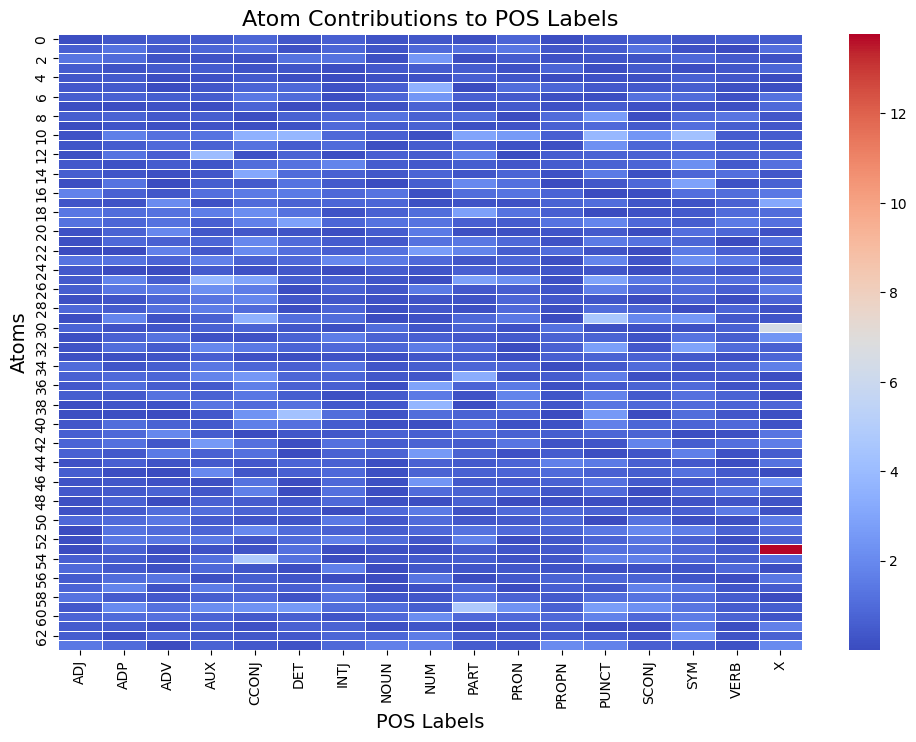

In [80]:
def plot_atom_pos_heatmap(model, pos_labels):
    pos_weights = np.abs(model.pos_classifier.weight.detach().cpu().numpy())  # Shape [k, num_pos]

    heatmap_data = pd.DataFrame(pos_weights.T, columns=pos_labels)

    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, cbar=True, linewidths=0.5)
    plt.title('Atom Contributions to POS Labels', fontsize=16)
    plt.xlabel('POS Labels', fontsize=14)
    plt.ylabel('Atoms', fontsize=14)
    plt.show()

plot_atom_pos_heatmap(model, le_pos.classes_)

In [75]:
# Extend existing `top_words_per_atom` by adding a `pos` column
top_words_with_pos = top_words_per_atom.copy()

# Merge back with the original dataset to get POS tag for each word/sentence pair
top_words_with_pos = top_words_with_pos.merge(
    df[['word', 'sentence', 'pos']],
    on=['word', 'sentence'],
    how='left'
)

# Replace any missing POS with "UNK"
top_words_with_pos['pos'] = top_words_with_pos['pos'].fillna("UNK")

def summarize_top_words_with_pos_style(top_words_with_pos, atom_indices, top_k=10):
    summary_rows = []

    for atom in atom_indices:
        df = top_words_with_pos[top_words_with_pos['atom'] == atom].head(top_k)
        words = df['word'].tolist()
        pos_tags = df['pos'].tolist()

        summary_rows.append({
            'Atom': atom,
            'Top Words': ", ".join(words),
            'POS Tags': ", ".join(pos_tags)
        })

    return pd.DataFrame(summary_rows)

selected_atoms = range(128)

summary_df = summarize_top_words_with_pos_style(
    top_words_with_pos=top_words_with_pos,
    atom_indices=selected_atoms,
    top_k=10
)

from IPython.display import display
display(summary_df)

,Atom,Top Words,POS Tags
0,0,"not, starts, not, not, law, not, these, proble...","PART, VERB, PART, PART, NOUN, PART, DET, NOUN,..."
1,1,"not, not, not, not, not, not, not, not, not, not","PART, PART, PART, PART, PART, PART, PART, PART..."
2,2,"do, do, do, in, rebound, action, hotel, hotels...","VERB, VERB, VERB, ADP, VERB, NOUN, NOUN, NOUN,..."
3,3,"Grover, Barnett, Sheets, Morse, Davenport, Hay...","PROPN, PROPN, PROPN, PROPN, PROPN, PROPN, PROP..."
4,4,"Orleans, year, site, college, Arkansas, year, ...","PROPN, NOUN, NOUN, NOUN, PROPN, NOUN, NOUN, AU..."
...,...,...,...
123,123,,
124,124,,
125,125,,
126,126,,
